In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from .startercode.example import example_use_of_gym_env

### What I wanna do
See what each environment looks like at the beginning
See how I can generate the environemet (or create a motion model, env model)
Play with the environment and see what actually happens
Develop a cost function
Write down a small model of the MDP/DP solving algorithm (either on the actual environement, or on the motion model)
Run the DP for one known environment where I can predict the optimal output
Run DP for all known environments
Create an overloaded state from the random env
Run for one random env
Run for all

In [2]:
from example import *
from utils import *
from doorkey import *
from create_env import *
from minigrid.core.world_object import Key, Wall,Door, Floor


pygame 2.5.2 (SDL 2.28.2, Python 3.9.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


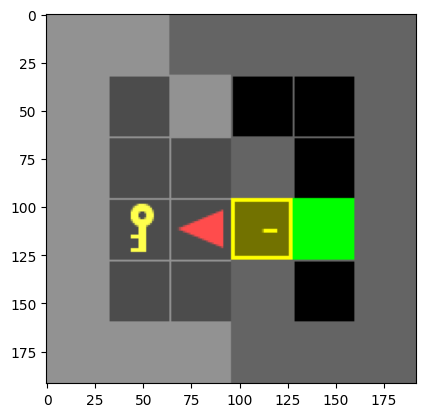

In [3]:
env_path = 'envs/known_envs/doorkey-6x6-shortcut.env'
env, info = load_env(env_path)
plot_env(env)
# trial_sequence = [MF, PK, TR, TR, UD, MF, MF, TL, MF, MF, MF]
# total_cost = 0
# state = [[1,1]]
# if(isinstance(env.unwrapped.carrying, Key)):
#     print(1)
# else:
#     print(0)
# # for action in trial_sequence:
# action = MF
# # step_cost, terminated , (obs, reward, terminated, truncated, info) = step(env, actions[action], state)
# step_cost = step(env, action, state, info['goal_pos'])
# total_cost += step_cost
# # if(isinstance(env.unwrapped.carrying, Key)):
# #     print(1)
# plot_env(env)
# print(total_cost, step_cost, state['terminated'], env.agent_pos ) #, (obs, reward, terminated, truncated, info))



### How to go about this
1. Create a stage cost function - cost = 1 if we are not in goal or 0 if we are in goal
2. Create a terminal cost function
3. Create a cost function
4. Define the state - needs agent pos, dir
5. How to define horizon? Not T, because in some world, we want to cover every state (imagine a long corridor where the key is at one end and the goal is at behind a wall) Number of steps ~ 2*num_locs


### Known

I have an environment and I want to create motion model for every state to it's next states

f[s][u] = s'
This I wil do by reloading the env everytime
Once I have the motion model (which is stationary), I can find the V[t][s] for each state by finding the min
At the same time I also update pi[t][s]
s = tuple(pos, dir, key, dooropen)

In [4]:
def make_motion_model(env_name, known = True):
    if known:
        env_path = 'envs/known_envs/' + env_name + '.env'
    else:
         env_path = 'envs/random_envs/' + env_name + '.env'
    env, info = load_env(env_path)
    layout = known_map_configs[env_name]['layout'] if known else None
    door_pos = info['door_pos']
    key_pos = info["key_pos"]
    goal = info['goal_pos']
    action_list = [MF, TL, TR, PK, UD]
    state_list = []
    pos_list = []
    f = {}
    c = {}
    # print(layout)
    if known:
        for i in range(layout.shape[0]):
            ii = i+1
            for j in range(layout.shape[1]):
                jj = j+1
                if layout[i,j] == WALL:
                    continue
                agent_pos = np.array([jj,ii])
                pos_list.append(agent_pos)
                for agent_dir in range(4):
                    for carrying_key in [False, True]:
                        for dooropen in [False, True]:
                            state = tuple((tuple(agent_pos), agent_dir, carrying_key, dooropen))
                            state_list.append(state)
                            f[state] = {}
                            c[state] = {}
                            for action in action_list:

                                env.unwrapped.agent_pos = agent_pos
                                env.unwrapped.agent_dir = agent_dir
                                if carrying_key :
                                    env.unwrapped.grid.set(key_pos[0], key_pos[1], None)
                                    env.unwrapped.carrying = Key(color='yellow')
                                else: 
                                    env.unwrapped.grid.set(key_pos[0], key_pos[1], Key('yellow'))
                                    env.unwrapped.carrying = None
                                if dooropen:
                                    env.unwrapped.grid.get(door_pos[0], door_pos[1]).is_open = True
                                    env.unwrapped.grid.get(door_pos[0], door_pos[1]).is_locked = False
                                else:
                                    env.unwrapped.grid.get(door_pos[0], door_pos[1]).is_open = False
                                    env.unwrapped.grid.get(door_pos[0], door_pos[1]).is_locked = True


                                cost = step(env, action, state, goal)
                                state_new = tuple((tuple(env.unwrapped.agent_pos), env.unwrapped.agent_dir , 
                                                                  isinstance(env.unwrapped.carrying, Key) , env.unwrapped.grid.get(door_pos[0], door_pos[1]).is_open))
                                f[state][action] = state_new
                                c[state][action] = cost
        return c, f, state_list, pos_list, action_list, info

# c, f, state_list, pos_list, action_list = make_motion_model('doorkey-6x6-shortcut', known = True)
# print(len(f.keys()), len(state_list), len(pos_list))
                        


In [5]:
def dp_known(env_name, known = True):
    V = {}
    policy = {}

    cost, f, state_list, _, action_list, info = make_motion_model(env_name, known = known)
    goal = info['goal_pos']
    

    T = len(state_list) - 1
    for t in range(T+1):
        V[t] = {}
        policy[t] = {}
        for state in state_list:
            if t == T :
                V[t][state] = 2*T
            if np.all(state[0] == goal):
                V[t][state] = 0
    
    for t in range(T-1, -1, -1):
        for state in state_list:
            V_min = np.inf
            u_min = 10
            for action in action_list:
                s_next = f[state][action]
                Q = cost[state][action] + V[t+1][s_next]
                if Q < V_min:
                    V_min = Q
                    u_min = action 
            V[t][state] = V_min
            policy[t][state] = u_min 
            
    agent_pos = info['init_agent_pos']
    agent_dir = info['init_agent_dir']
    carrying_key = False
    dooropen = False 
    state = tuple((tuple(agent_pos), agent_dir, carrying_key, dooropen))
    control_seq = []
    print(state)
    t= 0
    while not np.all(agent_pos == goal) and t < T:
        optim_action = policy[t][state]
        control_seq.append(optim_action)
        state = f[state][optim_action]
        agent_pos = state[0]
        t += 1
    
    return control_seq

((2, 1), 3, False, False)
[2, 0, 2, 3, 1, 4, 0, 0]


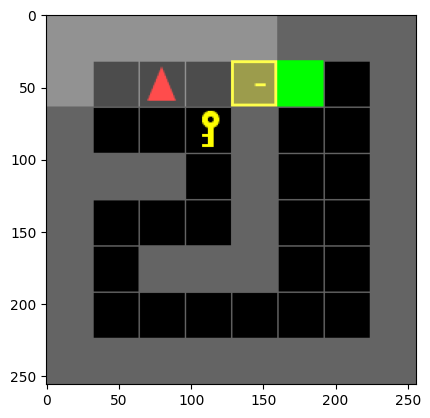

In [6]:
#@ One Example Run
env_name = 'doorkey-8x8-shortcut'
env_path = 'envs/known_envs/doorkey-8x8-shortcut.env'
control_seq = dp_known(env_name, known = True)
print(control_seq)
env, info = load_env(env_path)
plot_env(env)
goal = info['goal_pos']
door_pos = info['door_pos']
agent_dir = info['init_agent_dir']
agent_pos = info['init_agent_pos']
state = tuple((tuple(agent_pos), agent_dir, False, False))
# for action in control_seq:
    # print(action)
    # step(env, action, state, goal)
    # state = tuple((tuple(env.unwrapped.agent_pos), env.unwrapped.agent_dir , isinstance(env.unwrapped.carrying, Key) , env.unwrapped.grid.get(door_pos[0], door_pos[1]).is_open))
    # plot_env(env)

In [7]:
## Running for all
dirpath = "./envs/known_envs"
file_list = os.listdir(dirpath)
file_list = [file for file in file_list if file.endswith('env')]
file_dict = {}
# for file in file_list:
#     env_path = os.path.join(dirpath, file)
#     env_name = file[:-4]
#     print(env_name)
#     control_seq = dp_known(env_name, known = True)
#     env, info = load_env(env_path)
#     print(control_seq)
#     plot_env(env)
#     draw_gif_from_seq(control_seq, env,  path="./gif/" + env_name + ".gif")
#     file_dict[file] = control_seq
#     print('______________________________________')

# Part B - Random Environments

State =
pos
dir
key_loc
dooropen
key_pickup
goal_loc

In [10]:
def make_motion_model_random():
    env_name = 'DoorKey-8x8-1'
    env_path = './envs/random_envs/' + env_name + '.env'
    env, info, _ = load_random_env(env_path)

    key_state_list = range(4)
    key_loc_list = [(1,1),(2,3),(1,6)]

    goal_loc_list = [(5,1),(6,3),(5,6)]
    goal_state_list = range(3)
    
    door_state_list = [(False, False), (False, True), (True, False),(True, True)]
    door_loc_list = [(4,2), (4,5)]

    action_list = [MF, TL, TR, PK, UD]
    state_list = []
    pos_list = []
    f = {}
    c = {}
    # print(layout)
    width = info['width']
    height = info['height']
    for i in range(height ):
        ii = i
        for j in range(width ):
            jj = j
            agent_pos = np.array([jj,ii])
            ## Check for agent overlapping with wall 
            if isinstance(env.unwrapped.grid.get(jj, ii), Wall):
                print(f"Wall = {jj},{ii}")
                continue
            pos_list.append(agent_pos)
            for agent_dir in range(4):
                for door_state in door_state_list:
                    ## Check for agent and door overlap
                    if door_state[1] == False:
                        if np.all(agent_pos == door_loc_list[1]):
                            continue
                    if door_state[0] == False :
                        if np.all(agent_pos == door_loc_list[0]):
                            continue
                    for key_state in key_state_list:
                        ## Check for agent and key overlap
                        if key_state < 3:
                            if np.all(agent_pos == key_loc_list[key_state]):
                                continue
                        for goal_state in goal_state_list:
                            state = tuple((tuple(agent_pos), agent_dir, key_state, door_state, goal_state))
                            state_list.append(state)
                            f[state] = {}
                            c[state] = {}
                            for action in action_list:

                                ### Place key
                                for key_loc in key_loc_list:
                                    env.unwrapped.grid.set(key_loc[0], key_loc[1], None)
                                if key_state < 3:
                                    # carrying_key = False
                                    key_loc = key_loc_list[key_state]
                                    env.unwrapped.grid.set(key_loc[0], key_loc[1], Key('yellow'))
                                    env.unwrapped.carrying = None
                                else:
                                    # carrying_key = True
                                    env.unwrapped.carrying = Key('yellow')

                                ### Set a goal position
                                for goal_loc in goal_loc_list:
                                    env.unwrapped.grid.set(goal_loc[0], goal_loc[1], None)
                                goal = goal_loc_list[goal_state]
                                env.unwrapped.grid.set(goal[0], goal[1], Goal())

                                ### Seting up door
                                for k in [0,1]:
                                    if door_state[k] == False:
                                        env.unwrapped.grid.get(door_loc_list[k][0], door_loc_list[k][0]).is_open = False
                                        env.unwrapped.grid.get(door_loc_list[k][0], door_loc_list[k][0]).is_locked = True
                                    else: 
                                        env.unwrapped.grid.get(door_loc_list[k][0], door_loc_list[k][0]).is_open = True
                                        env.unwrapped.grid.get(door_loc_list[k][0], door_loc_list[k][0]).is_locked = False

                                ### Setting up agent pos and dir
                                env.unwrapped.agent_pos = agent_pos
                                env.unwrapped.agent_dir = agent_dir
                                # print('aaaaaaa')
                                # print(height)
                                # print(width)
                                # print(jj)
                                # print(ii)
                                # print(i)
                                # print(j)
                                # print(action)
                                # print(agent_dir)
                                # print(agent_pos)
                                # print(env.unwrapped.front_pos)

                                cost = step(env, action, state, goal)
                                agent_dir_new = env.unwrapped.agent_dir
                                agent_pos_new = tuple(env.unwrapped.agent_pos)
                                key_state_new = 3 if isinstance(env.unwrapped.carrying, Key) else key_state
                                door_state_new = (env.unwrapped.grid.get(door_loc_list[0][0], door_loc_list[0][1]).is_open  , env.unwrapped.grid.get(door_loc_list[1][0], door_loc_list[1][1]).is_open)
                                goal_state_new = goal_state
                                state_new = tuple((tuple(agent_pos_new), agent_dir_new, key_state_new, door_state_new, goal_state_new))
                                
                                f[state][action] = state_new
                                c[state][action] = cost
    return c, f, state_list, pos_list, action_list, info

# c, f, state_list, pos_list, action_list = make_motion_model('doorkey-6x6-shortcut', known = True)
# print(len(f.keys()), len(state_list), len(pos_list))
c, f, state_list, pos_list, action_list, info = make_motion_model_random()
print(len(state_list))

Wall = 4,0
Wall = 4,1
Wall = 4,3
Wall = 4,4
Wall = 4,6
Wall = 4,7
10800


/home/threevc/miniforge3/envs/276BECE/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.grid to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.grid` for environment variables or `env.get_wrapper_attr('grid')` that will search the reminding wrappers.
  logger.warn(


Wall = 4,0
Wall = 4,1
Wall = 4,3
Wall = 4,4
Wall = 4,6
Wall = 4,7


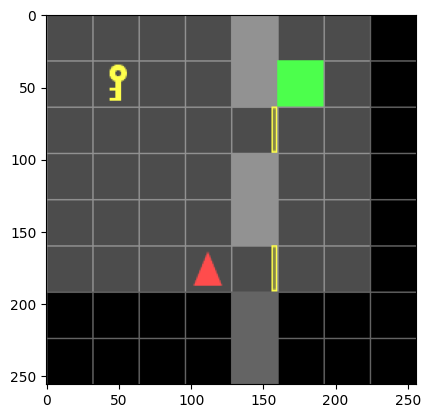

((3, 5), array([ 0, -1]), 0, (True, True), (5, 1))


TypeError: unhashable type: 'numpy.ndarray'

In [12]:
def dp_random(env_name):
    V = {}
    policy = {}

    cost, f, state_list, _, action_list, info = make_motion_model_random()
    # goal = info['goal_pos']
    key_loc_list = [(1,1),(2,3),(1,6)]
    env, info, _  = load_random_env('./envs/random_envs/' + env_name + '.env')
    plot_env(env)

    goal_loc_list = [(5,1),(6,3),(5,6)]

    T = len(state_list) - 1
    for t in range(T+1):
        V[t] = {}
        policy[t] = {}
        for state in state_list:
            goal = goal_loc_list[state[-1]]
            if t == T :
                V[t][state] = 2*T
            if np.all(state[0] == goal):
                V[t][state] = 0
    
    for t in range(T-1, -1, -1):
        for state in state_list:
            V_min = np.inf
            u_min = 10
            for action in action_list:
                s_next = f[state][action]
                Q = cost[state][action] + V[t+1][s_next]
                if Q < V_min:
                    V_min = Q
                    u_min = action 
            V[t][state] = V_min
            policy[t][state] = u_min 
            
    agent_pos = info['init_agent_pos']
    agent_dir = info['init_agent_dir']
    key_loc = info['key_pos']
    carrying_key = key_loc_list.index(tuple(key_loc))
    dooropen = tuple(info['door_open'])
    goal = tuple(info['goal_pos'])
    state = tuple((tuple(agent_pos), agent_dir, carrying_key, dooropen, goal))
    control_seq = []
    print(state)
    t= 0
    while not np.all(agent_pos == goal) and t < T:
        optim_action = policy[t][state]
        control_seq.append(optim_action)
        state = f[state][optim_action]
        agent_pos = state[0]
        t += 1
        print(t)
    print(control_seq)
    return control_seq
control_seq = dp_random('DoorKey-8x8-1')
# env = load_env()

In [ ]:
env_name = 'DoorKey-8x8-1'
env, info, _ = load_random_env('./envs/random_envs/' + env_name + '.env')
plot_env(env)


34 * 4 * 3  * 4 * 4
3 * 4 * 3 * 4
3 * 4 * 3 * 3 * 4 

In [10]:
print(list(range(8)))

[0, 1, 2, 3, 4, 5, 6, 7]
